# Object Description, part 1
The goal is to find a description of the object that adequately expresses its characteristics. This description can then be used, for example, for object classification.

## Region Labeling
- Assigns a unique identifier (label) to each connected region (object) in a binary or segmented image.
- In practice, label/color **collision** often occurs, especially with complex shapes like "U"-shaped objects, where different labels may get merged as the algorithm progresses. This requires a second pass to resolve label conflicts and ensure correct labeling.  
  ![RegionLabeling](https://miro.medium.com/v2/1*fccJzfWX8ii2kXqtPuwFcw.png)
  
## Common Object Descriptions
- **Size (Area)**: The total number of pixels forming the object.
- **Area Projection**: The projection of a shape into the x and y-axis image.
- **Euler Number**: $ E = S − N $, where $ S $ is number of connected components and $ N $ is number of holes in the region.
- **Eccentricity**: The ratio of the longest chord of the region to the longest distance perpendicular to that chord.
- **Elongation**: The ratio of the length to the width of the bounding rectangle with the smallest area that encloses the region.
- **Rectangularity**: The ratio of the region's area to the area of the bounding rectangle in the orientation of the region.
- **Orientation**: The angle of the region's principal axis, indicating its direction.
- **Perimeter**: The length of the closed boundary.
- **Compactness**: $ \text{compactness} = \frac{\text{perimeter}^2}{\text{size}} $  
  ![Compactness](https://user.engineering.uiowa.edu/~dip/lecture/Shape/f6.25.gif)
- **Convex Hull**: The smallest convex region that contains the entire object. It can be used to compare shapes by measuring the ratio of the object's area to its convex hull's area.  
  ![ConvexHull](https://cdn-images-1.medium.com/max/1200/1*F4IUmOJbbLMJiTgHxpoc7Q.png)

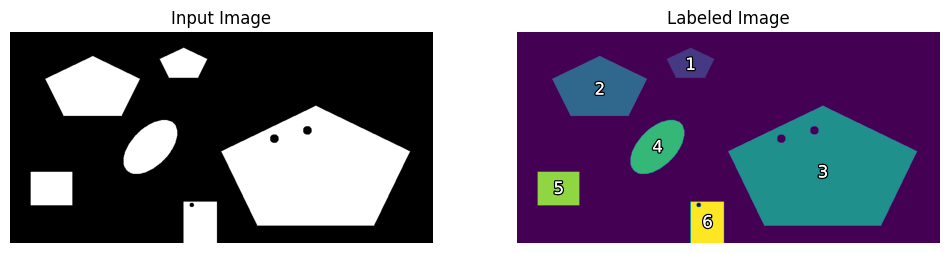

In [1]:
import numpy as np
from skimage import draw, measure
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Function to draw a pentagon
def draw_pentagon(center, size, image, color=255, rotation=0):
    width, height = size
    num_sides = 5
    angle_offset = np.pi / 2 + rotation
    points = []
    
    # Create vertices for the pentagon
    for i in range(num_sides):
        angle = i * 2 * np.pi / num_sides + angle_offset
        x = int(center[0] + (width / 2) * np.cos(angle))
        y = int(center[1] - (height / 2) * np.sin(angle))
        points.append((x, y))
    
    # Draw the pentagon
    rr, cc = draw.polygon([point[1] for point in points], [point[0] for point in points])
    rr = np.clip(rr, 0, image.shape[0] - 1)
    cc = np.clip(cc, 0, image.shape[1] - 1)
    image[rr, cc] = color

# Function to draw a rectangle
def draw_rectangle(center, size, image, color=255, rotation=0):
    width, height = size
    x_center, y_center = center
    half_width = width / 2
    half_height = height / 2

    # Define rectangle corners relative to center
    corners = [
        (-half_width, -half_height),
        (half_width, -half_height),
        (half_width, half_height),
        (-half_width, half_height),
    ]
    
    # Rotate corners around the center
    rotated_corners = []
    for x, y in corners:
        rotated_x = x * np.cos(rotation) - y * np.sin(rotation)
        rotated_y = x * np.sin(rotation) + y * np.cos(rotation)
        rotated_corners.append((x_center + rotated_x, y_center + rotated_y))
    
    # Draw the rectangle
    rr, cc = draw.polygon([int(corner[1]) for corner in rotated_corners], 
                          [int(corner[0]) for corner in rotated_corners])
    rr = np.clip(rr, 0, image.shape[0] - 1)
    cc = np.clip(cc, 0, image.shape[1] - 1)
    image[rr, cc] = color

# Function to draw an ellipse
def draw_ellipse(center, size, image, color=255, rotation=0):
    width, height = size
    radius_x = width / 2
    radius_y = height / 2
    x_center, y_center = center

    # Generate ellipse points
    t = np.linspace(0, 2 * np.pi, 100)
    x = radius_x * np.cos(t)
    y = radius_y * np.sin(t)

    # Apply rotation
    rotated_x = x * np.cos(rotation) - y * np.sin(rotation)
    rotated_y = x * np.sin(rotation) + y * np.cos(rotation)

    # Translate points to the center
    x_final = rotated_x + x_center
    y_final = rotated_y + y_center

    # Draw the ellipse
    rr, cc = draw.polygon(y_final.astype(int), x_final.astype(int), shape=image.shape)
    image[rr, cc] = color



# Image target size
height, width = 512, 1024

# Create a blank image
img = np.zeros((height, width), dtype=np.uint8)

# Small pentagon
draw_pentagon(center=(420, 80), size=(120, 80), image=img)
# Medium pentagon
draw_pentagon(center=(200, 140), size=(240, 160), image=img)
# Large pentagon with two holes
draw_pentagon(center=(740, 340), size=(480, 320), image=img)
draw_ellipse(center=(640, 260), size=(20, 20), image=img, color=0)
draw_ellipse(center=(720, 240), size=(20, 20), image=img, color=0)
# Ellipse
draw_ellipse(center=(340, 280), size=(160, 90), image=img, rotation=-(np.pi / 4))
# Rectangle
draw_rectangle(center=(100, 380), size=(100, 80), image=img)
# Rectangle with hole
draw_rectangle(center=(460, 462), size=(80, 100), image=img)
draw_ellipse(center=(440, 420), size=(10, 10), image=img, color=0)

# Label the objects in the image
labeled_img = measure.label(img, background=0)
label_names = ["small pentagon", "medium pentagon", "large pentagon w/ holes", "ellipse", "rectangle", "rectangle w/ hole"]

# Display the images side by side using matplotlib
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image (input image)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Input Image')
ax[0].axis('off')

# Display the labeled image
ax[1].imshow(labeled_img)
ax[1].set_title('Labeled Image')
ax[1].axis('off')

# Add numbers at the center of each labeled object
for region in measure.regionprops(labeled_img):
    # Get the center of the region
    cy, cx = region.centroid
    label = str(region.label)
    
    # Draw the label with a shadow effect for each character
    for i, char in enumerate(label):
        # Calculate the position of each character
        txt = ax[1].text(cx + i * 10, cy, char, color='white', fontsize=12, ha='center', va='center')

        # Add shadow effect
        txt.set_path_effects([path_effects.withStroke(linewidth=2, foreground='black'),
                              path_effects.Normal()])

# Show the plot
plt.show()

In [2]:
import pandas as pd

# Extract properties of labeled regions using regionprops
regions = measure.regionprops(labeled_img)

# Create a dictionary to store the results for each object
data = []

# Loop through each region and calculate the required descriptors
for region in regions:
    area = region.area
    
    # Convex hull area (convex boundary around the object)
    convex_area = region.convex_area
    
    # Bounding box
    y1, x1, y2, x2 = region.bbox
    width = x2 - x1
    height = y2 - y1
    
    # Euler number: E = S (number of components) - N (number of holes)
    euler_number = region.euler_number
    
    # Excentricity
    eccentricity = region.eccentricity
    
    # Rectangularity (area / area of bounding box)
    # - this simplified version assumes the object is aligned with the axes, and will not account for rotations
    rectangularity = region.area / (width * height) if width * height > 0 else 0
    
    # Elongation (aspect ratio between the bounding box's width and height)
    # - this simplified version assumes the object is aligned with the axes, and will not account for rotations
    elongation = max(width, height) / min(width, height) if min(width, height) > 0 else 0
    
    # Compactness = (perimeter^2) / area
    perimeter = region.perimeter
    compactness = perimeter ** 2 / area if area > 0 else 0
    
    # Direction - estimated by the principal axis of the object (orientation)
    direction = region.orientation
    
    # Store the data for the current region (object)
    data.append([
        area, convex_area, width, height, euler_number, eccentricity, rectangularity, elongation, perimeter, 
        compactness, direction
    ])

# Create a DataFrame to display the results in a tabular form
columns = [
    'Area (Size)', 'Convex Area', 'Width', 'Height', 'Euler Number', 'Eccentricity', 'Rectangularity', 'Elongation', 'Perimeter', 'Compactness', 'Direction'
]

df = pd.DataFrame(data, columns=columns, index=[f'{label_names[i]} (lbl {i+1})' for i in range(len(regions))]).T

# Display the results
df

,small pentagon (lbl 1),medium pentagon (lbl 2),large pentagon w/ holes (lbl 3),ellipse (lbl 4),rectangle (lbl 5),rectangle w/ hole (lbl 6)
Area (Size),5777.000000,22838.000000,90828.000000,11386.000000,8181.000000,8011.000000
Convex Area,5877.000000,23038.000000,91916.000000,11530.000000,8181.000000,8100.000000
Width,116.000000,230.000000,458.000000,130.000000,101.000000,81.000000
Height,73.000000,145.000000,290.000000,130.000000,81.000000,100.000000
Euler Number,1.000000,1.000000,-1.000000,1.000000,1.000000,0.000000
Eccentricity,0.747308,0.747589,0.748415,0.827378,0.597380,0.578412
Rectangularity,0.682215,0.684798,0.683843,0.673728,1.000000,0.989012
Elongation,1.589041,1.586207,1.579310,1.000000,1.246914,1.234568
Perimeter,316.178716,629.600072,1404.668181,422.274170,360.000000,395.798990
Compactness,17.304653,17.356872,21.723397,15.660941,15.841584,19.555217


**Note**  
In this example, **rectangularity** and **elongation** do not take rotation into account. This may result in incorrect values, as seen in the case of a rotated ellipse.

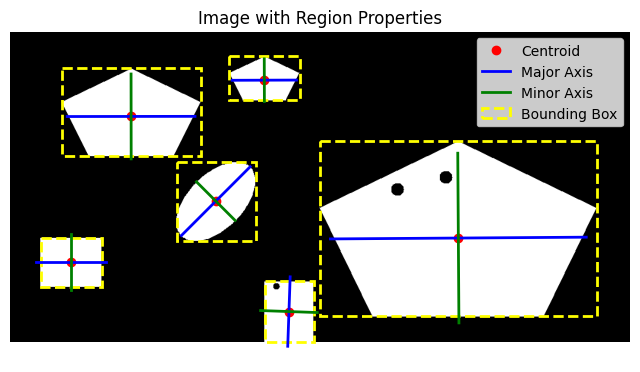

In [3]:
# Create a blank figure
fig, ax = plt.subplots(figsize=(8, 8))

# Display the original image
ax.imshow(img, cmap='gray')

# Loop through each region and plot the main and minor axes, centroid, etc.
for region in regions:
    # Coordinates for the centroid
    centroid = region.centroid
    
    # Coordinates for the major and minor axes
    major_axis_length = region.major_axis_length
    minor_axis_length = region.minor_axis_length
    orientation = region.orientation              # angle of the major axis with respect to the horizontal axis
    
    # Draw the centroid
    ax.plot(centroid[1], centroid[0], 'ro', label='Centroid' if 'Centroid' not in [line.get_label() for line in ax.lines] else "")
    
    # Draw the major axis
    angle = orientation
    ax.plot([centroid[1] - major_axis_length / 2 * np.sin(angle), centroid[1] + major_axis_length / 2 * np.sin(angle)],
            [centroid[0] - major_axis_length / 2 * np.cos(angle), centroid[0] + major_axis_length / 2 * np.cos(angle)],
            'b-', lw=2, label='Major Axis' if 'Major Axis' not in [line.get_label() for line in ax.lines] else "")
    
    # Draw the minor axis
    ax.plot([centroid[1] - minor_axis_length / 2 * np.cos(angle), centroid[1] + minor_axis_length / 2 * np.cos(angle)],
            [centroid[0] + minor_axis_length / 2 * np.sin(angle), centroid[0] - minor_axis_length / 2 * np.sin(angle)],
            'g-', lw=2, label='Minor Axis' if 'Minor Axis' not in [line.get_label() for line in ax.lines] else "")
    
    # Draw the bounding box (for visual reference)
    y1, x1, y2, x2 = region.bbox
    ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                linewidth=2, edgecolor='yellow', facecolor='none', linestyle='--', label='Bounding Box' if 'Bounding Box' not in [line.get_label() for line in ax.patches] else ""))

# Set plot titles and axes
ax.set_title('Image with Region Properties')
ax.axis('off')

# Show the legend
ax.legend()

# Show the plot
plt.show()

## Area Projection and Object Descriptors Correction (Individual Work)
**Objective**:
Implement the `area_projection` function to compute the projections of a **cropped object** along the x and y axes. **Visualize the results** by plotting both the original cropped object and its projections. Additionally, **correct the calculation of elongation and rectangularity** by considering the orientation of the object (`corrected_elongation_rectangularity` function).

**Instructions of one possible approach for the given object shapes**:
1. Area Projection:
   - For the cropped object in the image, compute **projections** along both the **x and y axes**.
2. Correct Elongation and Rectangularity:
   - First, **extract the orientation** of the object using the region properties (`measure.regionprops`).
   - Then, **rotate the object** based on the extracted orientation.
   - Finally, **recalculate** the elongation and rectangularity for the rotated object
3. Visualize and print results:
   - Show the cropped object along with its **projections along the x and y axes**.
   - **Compare the rotated object** with the original cropped object.
   - Print the **recalculated elongation and rectangularity** values.

**Note**:  
Both functions will have the **cropped object** as input, and they will return:
- `area_projection(img)` -> `projection_x`, `projection_y`  
  (Projections of the cropped object along the x and y axes.)
- `corrected_elongation_rectangularity(img)` -> `elongation`, `rectangularity`, `rotated_region`  
  (Recalculated elongation and rectangularity values, along with the rotated region after applying the orientation.)

### Code (scroll down)
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

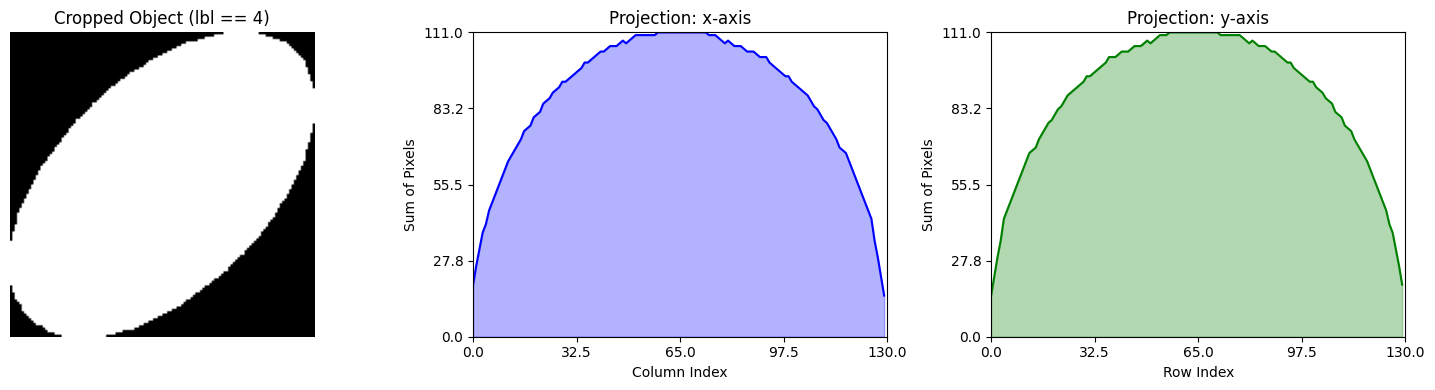

Corrected Elongation: 1.7777777777777777
Corrected Rectangularity: 0.7726388888888889


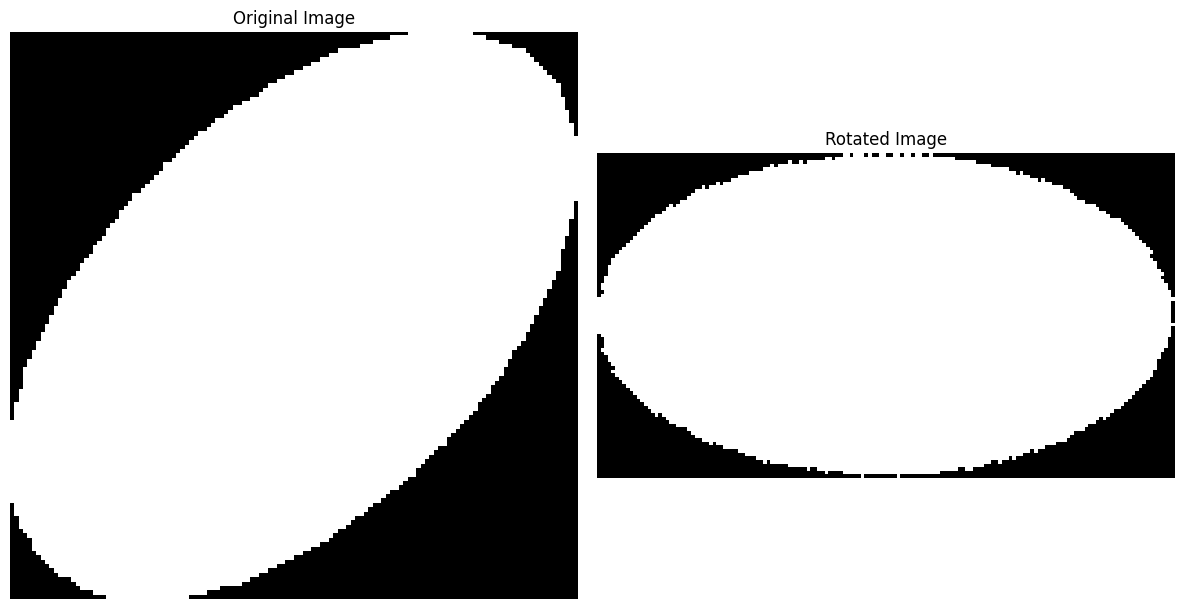

In [4]:
from skimage import transform

def area_projection(img):
    # Ensure the image is binary (True/False)
    img_binary = img.astype(bool)
    
    # The complete code will be provided during the exercise
    projection_x = None
    projection_y = None
    
    return projection_x, projection_y

def corrected_elongation_rectangularity(img):
    # The complete code will be provided during the exercise
    rotated_region = None
    rectangularity = None
    elongation = None
    
    # Return results
    return elongation, rectangularity, rotated_region

# Crop the object
label = 4
y1, x1, y2, x2 = regions[label - 1].bbox
cropped_obj = img[y1:y2, x1:x2]

# Get the projections
projection_x, projection_y = area_projection(cropped_obj)
elongation, rectangularity, rotated_region = corrected_elongation_rectangularity(cropped_obj)

# Plot and print the results
# - the complete code will be provided during the exercise


## Freeman's Chain Code
- **4-connectivity**: Describes the direction of movement between pixels using 4 directions (up, down, left, right).
- **8-connectivity**: Describes the direction of movement between pixels using 8 directions (including diagonals).  
  ![Freeman](https://www.cs.ru.nl/~ths/rt2/col/h9/new-chain.gif)<br><br>

- **Independence from the Start Point**: The smallest number of all possible strings.
- **Rotation Invariance**: Derivative to show changes in the direction of the boundary.

## Implement Freeman's Chain Code (individual work)
**Objective:**
Implement **Freeman's Chain Code** using an **8-neighborhood** to trace the boundary of an object in a binary image. The output should include a **visualization of the object contour** along with the corresponding **chain code**.

**Instructions:**
1. Implement the `freeman_chain` function that:
   - Takes a binary image as input.
   - Returns the **visited boundary points** and the **Freeman's Chain Code** (using the 8-neighborhood).
2. Print the obtained chain code and visualize the visited boundary points.
3. Try the function on different objects!

### Code (scroll down)
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

Freeman Chain Code: 5444544454454444545454545454545455545454555455545555555465555554655565556555655565556565656565656565656566665665666566666666666666666676676677766777777007770070070000000000000000001000100100001010101010101010101011101110111011101110211111102111111121112111212121112121212121212121222212212221222122222222222222322322322322333333334434434434434444444444444


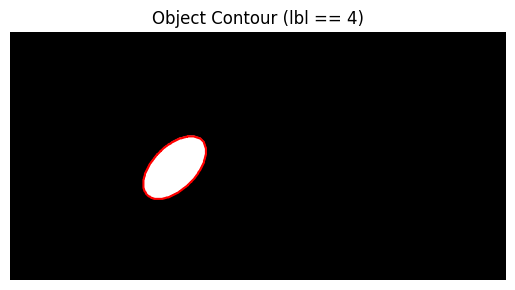

In [5]:
def freeman_chain(img):
    img = img.astype(bool)
    
    # The complete code will be provided during the exercise
    chain_code = list()
    visited = list()
    directions = [
        (0, 1),  # 0: right
        (-1, 1), # 1: up-right
        (-1, 0), # 2: up
        (-1, -1),# 3: up-left
        (0, -1), # 4: left
        (1, -1), # 5: down-left
        (1, 0),  # 6: down
        (1, 1),  # 7: down-right
    ]
    
    return np.array(visited), np.array(chain_code)


# Example usage
label = 3
binary_img = np.zeros(img.shape, dtype=bool)
binary_img[labeled_img == (label - 1)] = True

# Calculate Freeman Chain Code
visited, chain_code = freeman_chain(binary_img)

# Plot and print the results
# - the complete code will be provided during the exercise


# Next week - 2nd writing test!